In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
df_all_model = pd.read_parquet('../scripts/nway_csc21_gaia3_full_neg_study_dis_niter200.parquet')

In [3]:
# read vot to pandas ../data/all_stacks.vot
from astropy.io.votable import parse_single_table

# read vot to pandas
table = parse_single_table('../data/all_stacks.vot')

# recover column names
df_all_stacks = table.to_table().to_pandas()
df_all_stacks.columns = [col.name for col in table.fields]

In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 50})
    plt.title(title, fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()
    
    # percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 50})
    #plt.title(title + ' (Percentage)', fontsize=26)
    plt.ylabel('NWAY label', fontsize=26)
    plt.xlabel('Predicted label', fontsize=26)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.show()

In [5]:
from joblib import load

benchmark_ids = load('../scripts/jobs/models/neg_study_dis_niter200_withint_with_int_5X_lgbm_0-3_20241113_235113/benchmark_ids.joblib')

In [6]:
df_test = df_all_model[df_all_model['csc21_name'].isin(benchmark_ids)]

Interpolated value at y=0.015: 0.3174853372880061


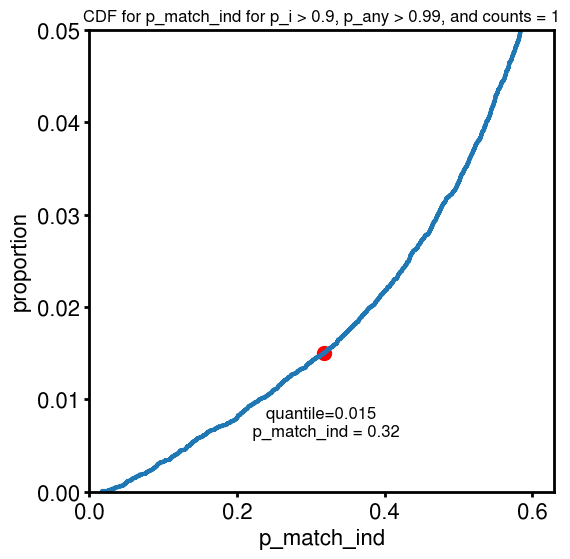

In [12]:
#### Threshold

# set plot parameters
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 16 
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['xtick.major.width'] = 2  
plt.rcParams['ytick.major.width'] = 2 

# filter dataframe
filtered_df = df_all_model[(df_all_model['p_i'] == 1) & (df_all_model['p_any'] > 0.99) & (df_all_model['count'] == 1) & (df_all_model['separation'] < 3)]

# plot cdf
fig, ax = plt.subplots(figsize=(6, 6))
sns.ecdfplot(filtered_df['p_match_ind'], linewidth=3, ax=ax)
plt.title('CDF for p_match_ind for p_i > 0.9, p_any > 0.99, and counts = 1', fontsize=12)
plt.xlabel('p_match_ind')
plt.ylabel('proportion')
plt.xlim(0, 0.63)
plt.ylim(0, 0.05)

# Interpolate the value at y=0.01
y_value = 0.015
x_value = np.interp(y_value, np.linspace(0, 1, len(filtered_df['p_match_ind'])), np.sort(filtered_df['p_match_ind']))
ax.scatter(x_value, y_value, color='red', s=100)
#x_value = np.percentile(filtered_df['p_match_ind'], 1)
print(f"Interpolated value at y={y_value}: {x_value}")
plt.annotate(f'quantile=0.015 \n p_match_ind = {x_value:.2f}', (x_value, y_value), textcoords="offset points", xytext=(0, -60), ha='center', fontsize=12)
plt.show()


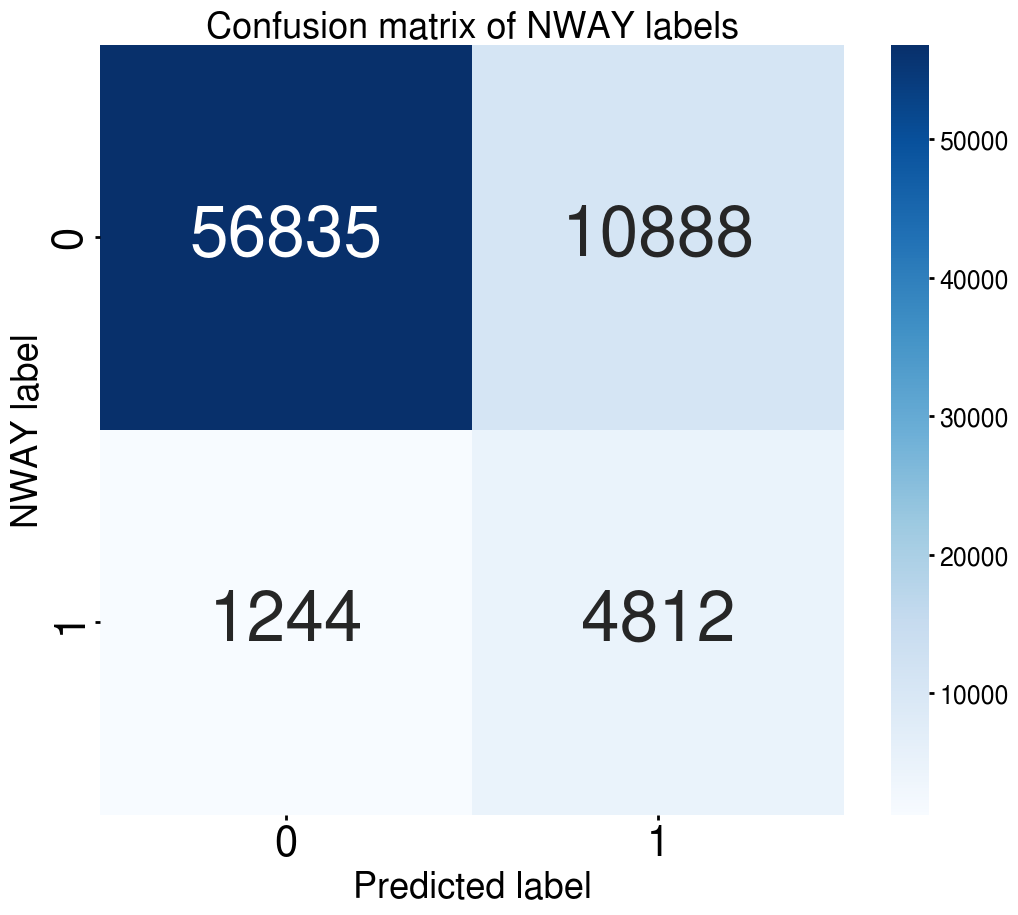

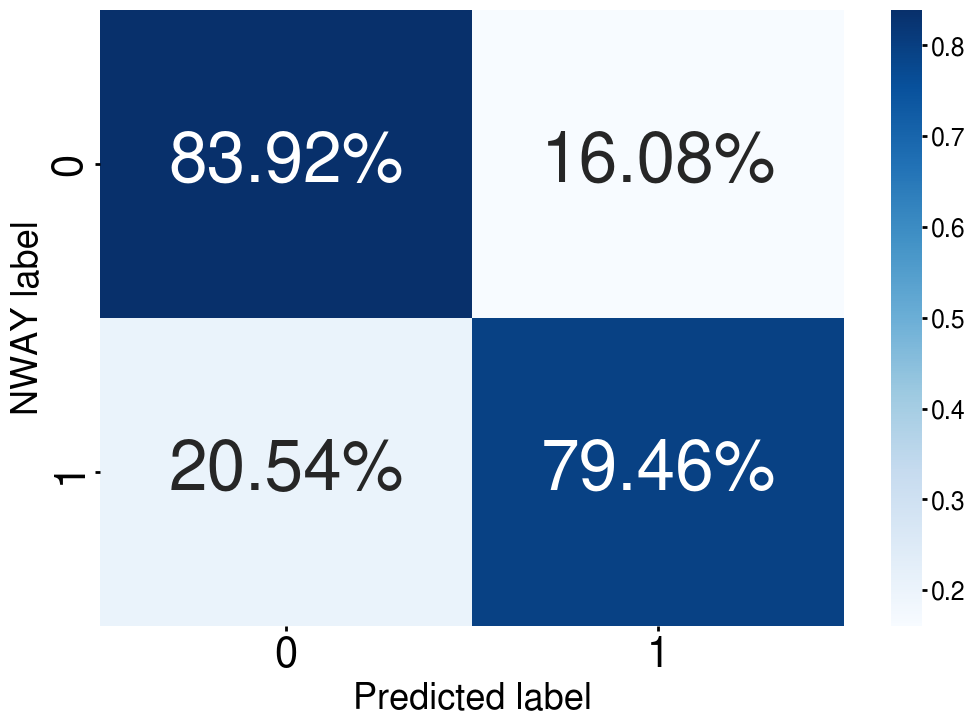

In [12]:
plot_confusion_matrix(df_test['match_flag'] == 1 , df_test['p_match_ind'] > 0.462, 'Confusion matrix of NWAY labels')

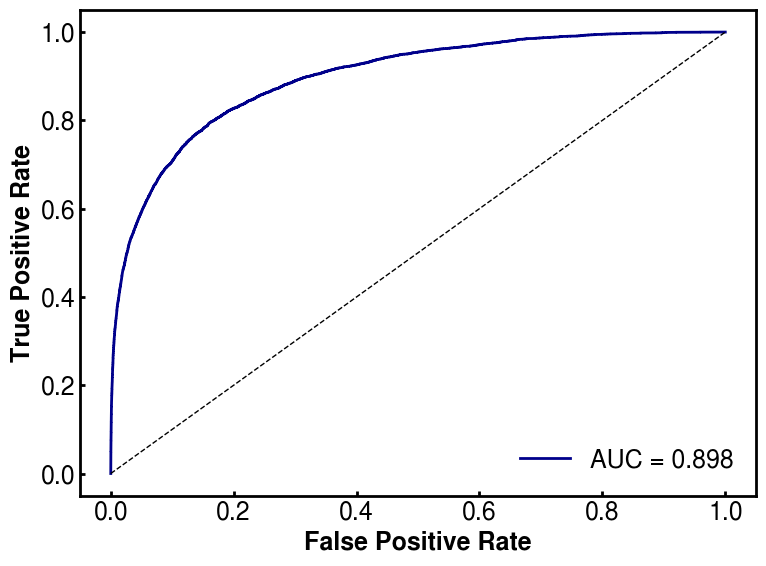

In [8]:
from sklearn.metrics import roc_curve, auc

# plotting params
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# calculate ROC
fpr, tpr, trs = roc_curve(df_test['match_flag'] == 1, df_test['p_match_ind'])
roc_auc = auc(fpr, tpr)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkblue', lw=2, 
        label=f'AUC = {roc_auc:.3f}')

# style
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate', weight='bold')
ax.set_ylabel('True Positive Rate', weight='bold')
ax.tick_params(direction='in', which='both')
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.show()

In [10]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = trs[optimal_idx]

In [11]:
optimal_threshold

0.46202266980354567

In [10]:
# Define the center of the Orion Nebula region
orion_center = SkyCoord(ra=83.8210 * u.deg, dec=-5.3944 * u.deg, frame='icrs')

# Create SkyCoord objects for all sources
orion_source_coords = SkyCoord(ra=df_all_model['csc21_ra'].values * u.deg, dec=df_all_model['csc21_dec'].values * u.deg, frame='icrs')

# Calculate separations
orion_separations = orion_source_coords.separation(orion_center).to(u.arcmin)

# Filter the dataframe
df_all_model['separation_from_orion'] = orion_separations
orion_sources_in_region = df_all_model[orion_separations <= 30 * u.arcmin]
orion_cscid_list = orion_sources_in_region['csc21_name'].str.replace('_', ' ').str.strip().unique().tolist()
orion_sources_in_region['num_possible_counterparts'] = orion_sources_in_region.groupby('csc21_name')['gaia3_source_id'].transform('count')


/tmp/ipykernel_613339/3012853408.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['num_possible_counterparts'] = orion_sources_in_region.groupby('csc21_name')['gaia3_source_id'].transform('count')


In [11]:
orion_sources_in_region['label'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform(lambda x: ((x == x.max()) & (x > 0.35) & (orion_sources_in_region['separation'] <= 2)).astype(int))

/tmp/ipykernel_613339/3016864526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['label'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform(lambda x: ((x == x.max()) & (x > 0.35) & (orion_sources_in_region['separation'] <= 2)).astype(int))


In [12]:
# Get cases with multiple possible matches
multi_matches = orion_sources_in_region.groupby('csc21_name').filter(lambda x: len(x) > 1)

# Find ambiguous NWAY cases
def is_ambiguous(group):
    sorted_pi = sorted(group['p_i'], reverse=True)
    return (sorted_pi[0] - sorted_pi[1]) < 0.1

ambiguous = multi_matches.groupby('csc21_name').filter(is_ambiguous)

# Check where ML model is confident
resolved = ambiguous[(ambiguous['label'] == 1)]

percentage = len(resolved['csc21_name'].unique()) / len(ambiguous['csc21_name'].unique()) * 100

In [13]:
import sys
sys.path.append('../')
from src.data import read_data, get_data_basic_matches, fast_random_match_duckdb

separation_threshold = 1.3
range_offaxis = '0-3'

df_pos, df_neg = get_data_basic_matches(df_all_model, range_offaxis, separation_threshold)


Range 0-3: 30279 positives, 310020 negatives


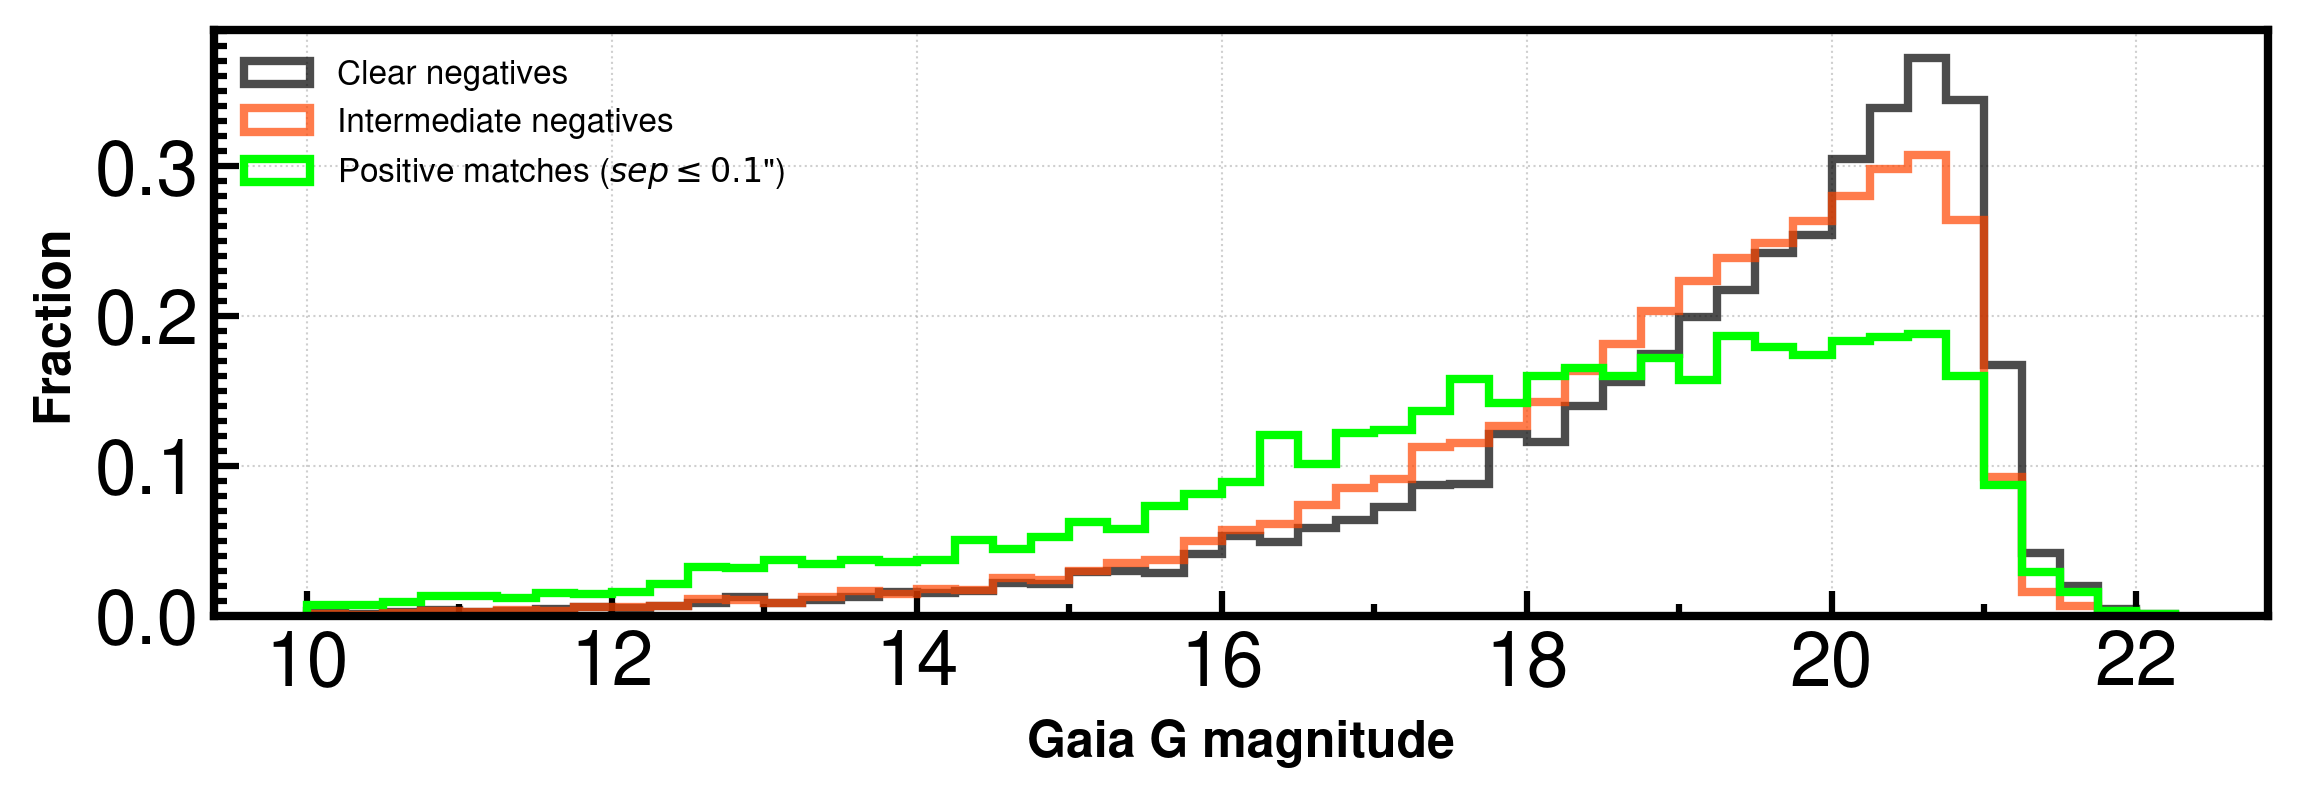

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# create figure with small size but high dpi for clarity
fig, ax = plt.subplots(figsize=(8,3), dpi=300)

bins = np.arange(10, 22.5, 0.25)
ax.hist(df_neg[df_neg['negative_type']=='clear_negative']['phot_g_mean_mag'],
       bins=bins, density=True, histtype='step',
       color='black', label='Clear negatives', linewidth=2, alpha=0.7)

ax.hist(df_neg[df_neg['negative_type']=='intermediate']['phot_g_mean_mag'],
       bins=bins, density=True, histtype='step',
       color='orangered', label='Intermediate negatives', linewidth=2, alpha=0.7)


# plot thicker histograms
ax.hist(df_pos.query('separation <= 0.1')['phot_g_mean_mag'], bins=bins, density=True, histtype='step',
       color='lime', label=r'Positive matches ($sep\leq0.1$")', linewidth=2)




# style ticks and lines
ax.tick_params(direction='in', width=1.5, length=6, which='major')
ax.tick_params(direction='in', width=1.5, length=3, which='minor')
#tick frequency high
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.grid(True, linestyle=':', alpha=0.6, linewidth=0.5)

# prominent labels
ax.set_xlabel('Gaia G magnitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Fraction', fontsize=12, fontweight='bold')
#ax.set_xlim(10, 22))

# make legend compact
ax.legend(fontsize=8, frameon=False)

plt.tight_layout()
plt.savefig('magnitude_distribution.png', dpi=300, bbox_inches='tight')

In [8]:
csc21_names_with_label_1 = orion_sources_in_region[orion_sources_in_region['label'] == 1]['csc21_name'].unique()
csc21_names_with_label_1

array(['2CXO J053346.0-053425', '2CXO J053354.5-053159',
       '2CXO J053357.8-053626', ..., '2CXO J053617.0-051142',
       '2CXO J053618.9-051827', '2CXO J053621.3-052014'], dtype=object)

In [16]:
# Filter the dataframe to include only sources with a potential match
matched_sources = orion_sources_in_region[orion_sources_in_region['csc21_name'].isin(csc21_names_with_label_1)]

NameError: name 'csc21_names_with_label_1' is not defined

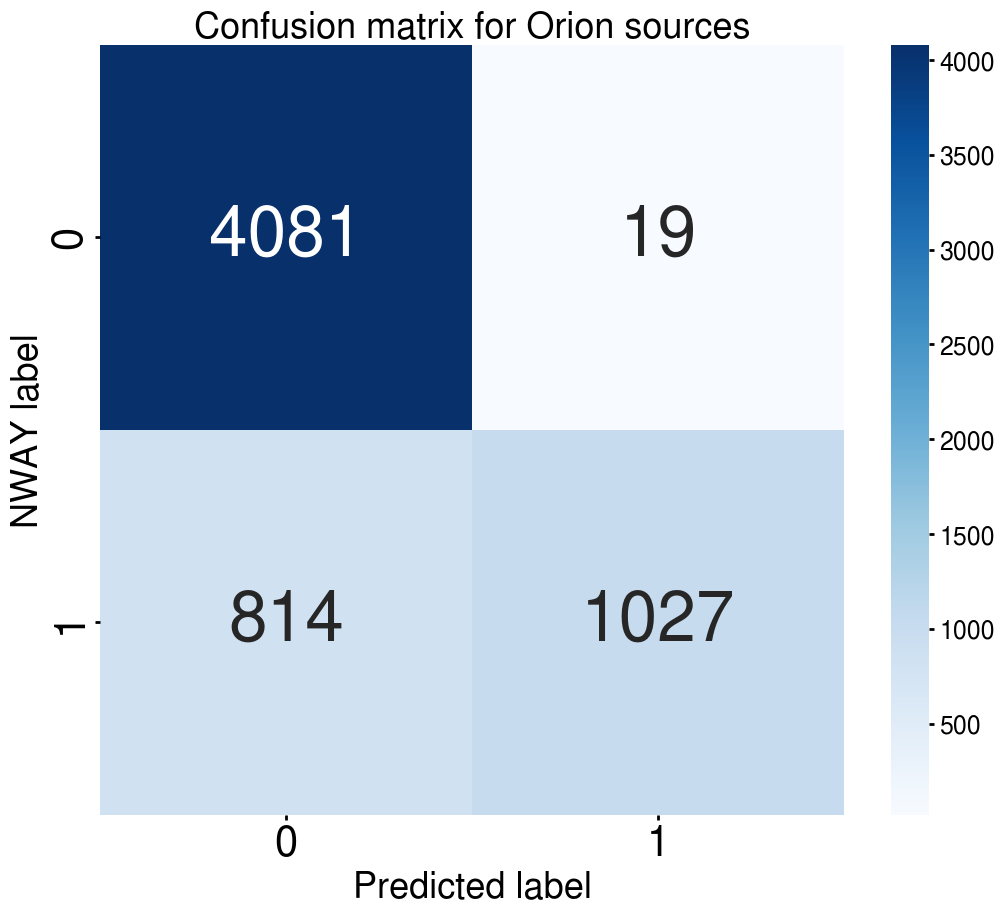

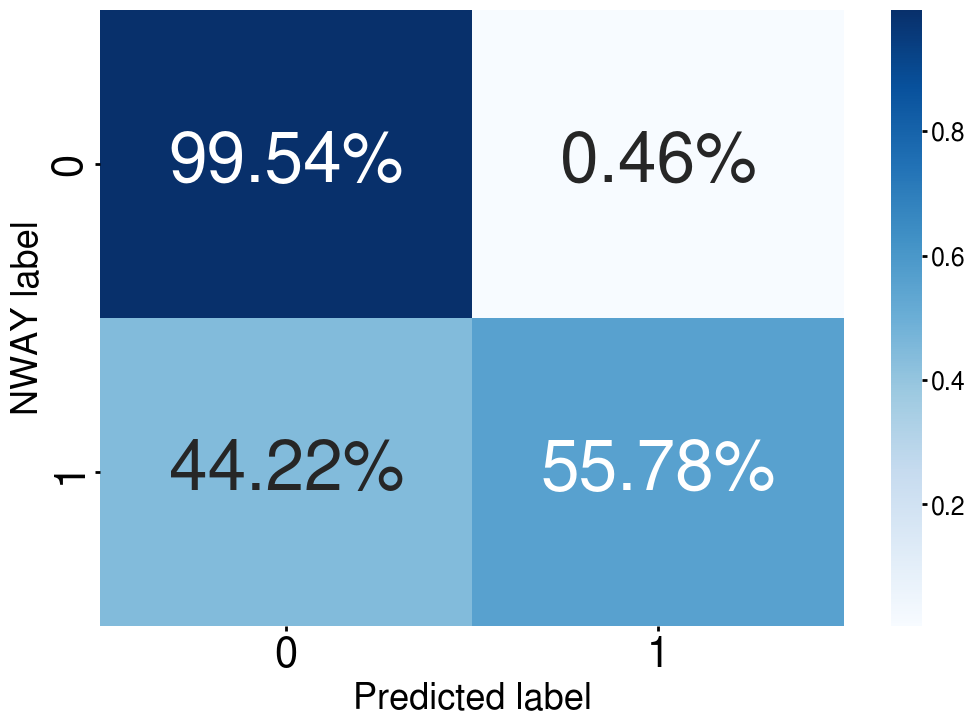

In [15]:
y_true = (orion_sources_in_region['match_flag'] == 1 ).astype(int)
y_pred = orion_sources_in_region['label']

plot_confusion_matrix(y_true, y_pred, 'Confusion matrix for Orion sources')

In [16]:
def analyze_flips_to_zero(y_true, y_pred):
    """
    Analyze proportion of 1's that flipped to 0's in predictions
    
    Args:
        y_true: Array of true labels (0/1)
        y_pred: Array of predicted labels (0/1)
    Returns:
        dict: Statistics about 1->0 flips
    """
    import numpy as np
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Find 1->0 flips and count total 1's
    flipped_1_to_0 = np.logical_and(y_true == 1, y_pred == 0)
    total_ones = (y_true == 1).sum()
    
    n_flipped_1_to_0 = flipped_1_to_0.sum()
    
    return {
        'total_ones': total_ones,
        'flipped_1_to_0': n_flipped_1_to_0,
        'proportion_ones_flipped': n_flipped_1_to_0 / total_ones if total_ones > 0 else 0
    }

In [17]:
analyze_flips_to_zero(y_true, y_pred)

{'total_ones': 1841,
 'flipped_1_to_0': 814,
 'proportion_ones_flipped': 0.44215100488864745}

In [18]:
def analyze_flips_with_nway(df, y_true, y_pred):
    """checks which flipped predictions had valid nway matches"""
    
    # find flips from 1->0
    flips = df[np.logical_and(y_true == 1, y_pred == 0)].copy()
    
    # check which flips had valid nway matches
    valid_nway = flips.query('min_theta_mean < 3 and separation <= 1.3 and p_any >= 0.5')
    
    print(f"Total flips 1->0: {len(flips)}")
    print(f"Flips with valid NWAY matches: {len(valid_nway)}")
    
    return valid_nway[['csc21_name', 'separation', 'min_theta_mean', 'p_any', 'p_match_ind']]

In [19]:
analyze_flips_with_nway(orion_sources_in_region, y_true, y_pred)

Total flips 1->0: 814
Flips with valid NWAY matches: 226


,csc21_name,separation,min_theta_mean,p_any,p_match_ind
1054654,2CXO J053438.2-053450,0.071451,1.999958,0.999709,0.521160
1054745,2CXO J053446.9-053503,0.082394,1.470796,0.999830,0.826007
1054754,2CXO J053447.6-053111,0.194944,2.592263,0.999616,0.766756
1054780,2CXO J053448.9-053131,0.167573,2.393726,0.999596,0.842696
1055143,2CXO J053504.0-054051,0.140914,0.441115,0.999811,0.817164
...,...,...,...,...,...
1060047,2CXO J053527.4-051711,0.315014,2.239638,0.998955,0.830495
1060052,2CXO J053527.5-051655,0.244309,2.405385,0.999529,0.695438
1060106,2CXO J053528.3-051754,0.186617,2.170960,0.999658,0.770626
1060216,2CXO J053530.7-051806,0.111954,2.717666,0.999837,0.893007


In [ ]:
def analyze_matching_cascade(df):
    n_total = len(df['csc21_name'].unique())
    print(f"Total CSC sources: {n_total}")
    n_inner = df.query('min_theta_mean < 3')['csc21_name'].nunique()
    n_middle = df.query('min_theta_mean >= 3 and min_theta_mean <=5')['csc21_name'].nunique()
    nway_outer = df.query('min_theta_mean > 5')['csc21_name'].nunique()

    print(f"Total CSC sources with nway matches: {n_inner + n_middle + nway_outer}")
    print(f"Inner region (<3'): {n_inner}")
    print(f"Middle region (3'-5'): {n_middle}")
    print(f"Outer region (>5'): {nway_outer}")
    
    # 2. nway matches by theta ranges
    nway_inner = df[(df['min_theta_mean'] < 3) & 
                    (df['separation'] < 1.2) & 
                    (df['p_any'] > 0.5)]['csc21_name'].nunique()
                    
    nway_middle = df[(df['min_theta_mean'].between(3, 5)) & 
                     (df['separation'] < 2.0) & 
                     (df['p_any'] > 0.5)]['csc21_name'].nunique()
                     
    nway_outer = df[(df['min_theta_mean'] > 5) & 
                    (df['separation'] < 2.5) & 
                    (df['p_any'] > 0.5)]['csc21_name'].nunique()

    # 3a. deprecations
    deprecations = df[(df['match_flag'] == 1) & 
                     (df['p_match_ind'] < 0.35)]['csc21_name'].nunique()
    dep_df = df[(df['match_flag'] == 1) & 
                     (df['p_match_ind'] < 0.35)]
    
    dep_inner = dep_df.query('min_theta_mean < 3')['csc21_name'].nunique()
    dep_middle = dep_df.query('min_theta_mean >= 3 and min_theta_mean <=5')['csc21_name'].nunique()
    dep_outer = dep_df.query('min_theta_mean > 5')['csc21_name'].nunique()

    # 3b. different matches by separation threshold
    def get_different_matches(theta_min, theta_max, sep_threshold):
        mask = df['min_theta_mean'].between(theta_min, theta_max)
        return df[mask].groupby('csc21_name').apply(
            lambda x: (x['separation'].min() < sep_threshold) and
                    (x['p_i'].idxmax() != x['p_match_ind'].idxmax()) and
                    (x['p_match_ind'].max() > 0.35) and
                    (x.iloc[x['p_match_ind'].argmax()]['separation'] < sep_threshold)
        ).sum()

    different_matches = {
        'total': get_different_matches(-float('inf'), float('inf'), 2.5),
        '<3\' (sep<1.2")': get_different_matches(0, 3, 1.2),
        '3\'-5\' (sep<2.0")': get_different_matches(3, 5, 2.0),
        '>5\' (sep<2.5")': get_different_matches(5, float('inf'), 2.5)
    }

    def check_invalid_suggestions(theta_min, theta_max, sep_threshold):
        mask = df['min_theta_mean'].between(theta_min, theta_max)
        no_nway = df[mask].groupby('csc21_name').filter(
            lambda x: all(~(x['separation'] < sep_threshold))  # no nway matches within threshold
        )

        print(no_nway.separation.min()) 
        print(no_nway.iloc[no_nway['p_match_ind'].argmax()]['separation'])
        
        return no_nway.groupby('csc21_name').apply(
            lambda x: (x['p_match_ind'].max() > 0.35) and 
                    (x.iloc[x['p_match_ind'].argmax()]['separation'] < sep_threshold)
        ).sum()

    invalid_suggestions = {
        '<3\' (1.2")': check_invalid_suggestions(0, 3, 1.3),
        '3\'-5\' (2.0")': check_invalid_suggestions(3, 5, 2.0),
        '>5\' (2.5")': check_invalid_suggestions(5, float('inf'), 10)
    }

    return {
        'total': n_total,
        'nway_matches': {
            '<3\'': nway_inner,
            '3\'-5\'': nway_middle, 
            '>5\'': nway_outer
        },
        'deprecations': deprecations,
        'deprecations_by_theta': {
            '<3\'': dep_inner,
            '3\'-5\'': dep_middle,
            '>5\'': dep_outer
        },
        'different_matches': different_matches,
        'invalid_suggestions': invalid_suggestions
    }

In [65]:
analyze_matching_cascade(orion_sources_in_region)

Total CSC sources: 1841
Total CSC sources with nway matches: 1841
Inner region (<3'): 786
Middle region (3'-5'): 390
Outer region (>5'): 665


/tmp/ipykernel_613339/1108224820.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[mask].groupby('csc21_name').apply(
/tmp/ipykernel_613339/1108224820.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df[mask].groupby('csc21_name').apply(
/tmp/ipykernel_613339/1108224820.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, an

2.03388
12.00698


/tmp/ipykernel_613339/1108224820.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return no_nway.groupby('csc21_name').apply(
/tmp/ipykernel_613339/1108224820.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return no_nway.groupby('csc21_name').apply(


12.46879


/tmp/ipykernel_613339/1108224820.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return no_nway.groupby('csc21_name').apply(


{'total': 1841,
 'nway_matches': {"<3'": 537, "3'-5'": 326, ">5'": 544},
 'deprecations': 124,
 'deprecations_by_theta': {"<3'": 84, "3'-5'": 16, ">5'": 24},
 'different_matches': {'total': 25,
  '<3\' (sep<1.2")': 1,
  '3\'-5\' (sep<2.0")': 3,
  '>5\' (sep<2.5")': 17},
 'invalid_suggestions': {'<3\' (1.2")': 0,
  '3\'-5\' (2.0")': 0,
  '>5\' (2.5")': 0}}

In [35]:
# how many stacks are in the csc over this fov?
n_stacks = df_all_stacks[df_all_stacks['name'].isin(orion_sources_in_region['csc21_name'].unique())]['detect_stack_id'].nunique()


In [43]:
df_all_stacks[df_all_stacks['name'].isin(orion_sources_in_region['csc21_name'].unique())]['detect_stack_id'].unique()

array(['acisfJ0534448m053346_001', 'acisfJ0535058m054048_001',
       'acisfJ0535165m052323_001', 'hrcfJ0535167m052340_001',
       'acisfJ0535193m044814_001', 'acisfJ0535198m051822_001',
       'acisfJ0535319m045931_001'], dtype=object)

In [36]:
n_stacks

7

In [40]:
def analyze_different_match_separations(df):
    def get_separation_diffs(theta_min, theta_max, sep_threshold):
        mask = df['min_theta_mean'].between(theta_min, theta_max)
        matches = df[mask].groupby('csc21_name').filter(
            lambda x: (x['separation'].min() < sep_threshold) and
                     (x['p_i'].idxmax() != x['p_match_ind'].idxmax()) and
                     (x['p_match_ind'].max() > 0.35) and
                      (x.iloc[x['p_match_ind'].argmax()]['separation'] < sep_threshold)
        )
        
        # for each csc source, get separations of nway vs model match
        diffs = []
        for _, group in matches.groupby('csc21_name'):
            nway_sep = group[group['p_i'] == group['p_i'].max()]['separation'].iloc[0]
            model_sep = group[group['p_match_ind'] == group['p_match_ind'].max()]['separation'].iloc[0]
            print(nway_sep, model_sep)
            diffs.append(model_sep - nway_sep)
        print(len(diffs))
        return np.array(diffs)
    
    # plot for each theta range
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    diffs_inner = get_separation_diffs(0, 3, 1.2)
    diffs_middle = get_separation_diffs(3, 5, 2.0)
    diffs_outer = get_separation_diffs(5, float('inf'), 2.5)
    
    ax1.hist(diffs_inner, bins=50)
    ax1.set_title(f'θ < 3\' (n={len(diffs_inner)})')
    
    ax2.hist(diffs_middle, bins=50)
    ax2.set_title(f'3\' < θ < 5\' (n={len(diffs_middle)})')
    ax2.set_xlabel('Separation difference (model - NWAY) [arcsec]')
    
    ax3.hist(diffs_outer, bins=50)
    ax3.set_title(f'θ > 5\' (n={len(diffs_outer)})')
    
    return diffs_inner, diffs_middle, diffs_outer

0.1409142 0.9904301
1
0.6594208 1.861788
0.2094692 0.4969672
0.1997391 1.723006
3
0.5145133 1.157457
0.8016321 2.013969
0.710484 1.098588
0.07160215 2.071048
0.9047325 1.29591
0.09171403 0.2939312
0.04789838 0.4712988
1.214323 2.311031
0.134797 1.173778
1.251984 1.390748
0.9075823 0.9986397
0.2259177 1.61781
0.2743 0.3367128
0.5377857 0.6465577
0.7949862 1.210707
0.6038758 1.43152
1.513608 2.36959
17


(array([0.8495159], dtype=float32),
 array([1.2023673, 0.287498 , 1.5232669], dtype=float32),
 array([0.6429437 , 1.2123368 , 0.38810396, 1.9994459 , 0.39117748,
        0.20221716, 0.42340043, 1.096708  , 1.0389811 , 0.13876402,
        0.09105742, 1.3918923 , 0.0624128 , 0.10877198, 0.41572076,
        0.82764417, 0.85598207], dtype=float32))

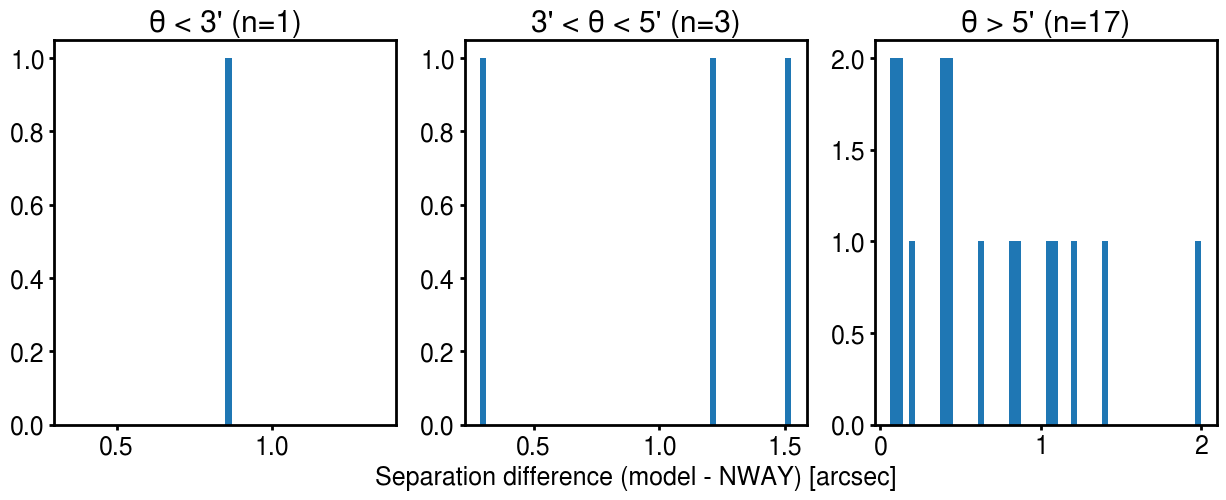

In [41]:
analyze_different_match_separations(orion_sources_in_region)

In [69]:
def analyze_model_preferred_matches(df):
    def check_model_choices(theta_min, theta_max, sep_threshold):
        mask = df['min_theta_mean'].between(theta_min, theta_max)
        different_matches = df[mask].groupby('csc21_name').filter(
            lambda x: (x['separation'].min() < sep_threshold) and
                     (x['p_i'].idxmax() != x['p_match_ind'].idxmax()) and 
                     (x['p_match_ind'].max() > 0.35)
        )
        
        count = 0
        total = 0
        for csc_id in different_matches['csc21_name'].unique():
            group = different_matches[different_matches['csc21_name'] == csc_id]
            # get gaia id that model preferred
            model_gaia_id = group.loc[group['p_match_ind'].idxmax(), 'gaia3_source_id']
            # check if this gaia id has a match_flag=1 with another csc source
            has_other_match = df[
                (df['gaia3_source_id'] == model_gaia_id) & 
                (df['match_flag'] == 1) & 
                (df['csc21_name'] != csc_id)
            ].any().any()
            
            total += 1
            if has_other_match:
                count += 1
                
        return count, total

    return {
        '<3\'': check_model_choices(0, 3, 1.2),
        '3\'-5\'': check_model_choices(3, 5, 2.0),
        '>5\'': check_model_choices(5, float('inf'), 2.5)
    }

In [70]:
analyze_model_preferred_matches(orion_sources_in_region)

{"<3'": (218, 230), "3'-5'": (74, 84), ">5'": (51, 88)}

In [12]:
# for each pair, find if it's the best match for both sources
orion_sources_in_region['best_for_xray'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']
orion_sources_in_region['best_for_gaia'] = orion_sources_in_region.groupby('gaia3_source_id')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']

/tmp/ipykernel_4186513/928954300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['best_for_xray'] = orion_sources_in_region.groupby('csc21_name')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']
/tmp/ipykernel_4186513/928954300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orion_sources_in_region['best_for_gaia'] = orion_sources_in_region.groupby('gaia3_source_id')['p_match_ind'].transform('max') == orion_sources_in_region['p_match_ind']


In [ ]:
gaia_matched = matched_sources.gaia3_source_id.unique()
# look at these sources in df_all_model
df_all_model.query('gaia3_source_id in @matched_sources.gaia3_source_id.unique()')

array(['3209415239649017856', '3209415759341159808',
       '3209415759342173696', ..., '3017368530095330432',
       '3017356602958232064', '3017356607266117760'], dtype=object)

In [19]:
non_best_matches = matched_sources[
   (matched_sources.match_flag != 1) & 
   (matched_sources.label == 1)
]
gaia_ids_non_best = non_best_matches.gaia3_source_id.unique()

In [22]:
matches_to_check = orion_sources_in_region[
   (orion_sources_in_region.gaia3_source_id.isin(gaia_ids_non_best)) &
   (orion_sources_in_region.label == 0) & 
   (orion_sources_in_region.separation <= 2)
]

In [38]:
matches_to_check

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1060041,2CXO J053527.4-051709,83.864471,-5.285991,0.159315,0.134805,94.0,-0.242349,0.017489,-0.150531,0.189257,...,1.0,1,6,3.278312,0.933465,7.003824,6,0,False,False


In [83]:
src_interest = orion_sources_in_region.query('gaia3_source_id == "3017367258785044224" and separation <= 5')

In [89]:
src_interest

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1060034,2CXO J053527.3-051712,83.863770,-5.286752,0.232845,0.187910,96.599998,0.082448,0.228607,-0.217989,0.615240,...,0.000000e+00,0,4,3.278312,0.809235,6.945900,4,0,False,False
1060041,2CXO J053527.4-051709,83.864471,-5.285991,0.159315,0.134805,94.000000,-0.242349,0.017489,-0.150531,0.189257,...,1.000000e+00,1,6,3.278312,0.933465,7.003824,6,0,False,False
1060046,2CXO J053527.4-051711,83.864449,-5.286551,0.302290,0.232845,99.400002,-0.742036,0.279825,-0.217989,0.690194,...,1.233886e-13,0,4,3.278312,0.906157,6.972140,4,1,True,False


In [92]:
orion_sources_in_region[orion_sources_in_region['csc21_name'] == '2CXO J053527.4-051711'][['min_theta_mean', 'gaia3_source_id', 'p_match_ind', 'separation', 'label', 'match_flag']]

,min_theta_mean,gaia3_source_id,p_match_ind,separation,label,match_flag
1060044,2.239638,3017366502870800512,0.892640,12.204260,0,0
1060045,2.239638,3017367258772449920,0.717550,2.485025,0,0
1060046,2.239638,3017367258785044224,0.906157,1.889382,1,0
1060047,2.239638,3017367258785044480,0.830495,0.315014,0,1


In [45]:
import matplotlib.pyplot as plt
from astroquery.hips2fits import hips2fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes

# get central coords from reference match
ref_csc = orion_sources_in_region.query(
   'csc21_name == "2CXO J053523.0-052836" and separation <= 4'
).iloc[0]

ref= orion_sources_in_region.query(
   'csc21_name == "2CXO J053523.0-052836" and separation <= 10'
)

ref2 = orion_sources_in_region.query(
   'csc21_name == "2CXO J053523.2-052832" and separation <= 4'
).iloc[0]

# get jwst miri image
hips = 'CDS/P/2MASS/J'
result = hips2fits.query(
   hips=hips,
   width=800, height=800,
   ra=ref_csc.csc21_ra*u.deg,
   dec=ref_csc.csc21_dec *u.deg,
   fov=0.004 *u.deg,
   projection='TAN'
)

In [42]:
# base plot settings
wcs = WCS(result[0].header)
fig = plt.figure(figsize=(10,10), dpi=300)
ax = WCSAxes(fig, [0.1,0.1,0.8,0.8], wcs=wcs)
fig.add_axes(ax)

# image with better contrast
norm = ImageNormalize(result[0].data, interval=AsymmetricPercentileInterval(5,99))
ax.imshow(result[0].data, cmap='inferno', norm=norm, origin='lower')

# plot CSC sources with labels
ax.scatter([ref_csc.csc21_ra, ref2.csc21_ra], 
         [ref_csc.csc21_dec, ref2.csc21_dec],
         transform=ax.get_transform('world'),
         color='red', marker='*', s=200, label='CSC Sources')

# plot COUP sources  
coup_coords = pd.DataFrame({
   'name': ['COUP 1238', 'COUP 1243'],
   'ra': [083.846230, 083.846894], 
   'dec': [-05.476920, -05.476029]
})
ax.scatter(coup_coords.ra, coup_coords.dec,
         transform=ax.get_transform('world'),
         color='yellow', marker='s', s=150, label='COUP')


ax.scatter(ref.gaia3_ra.values, ref.gaia3_dec.values,
            transform=ax.get_transform('world'), 
            color='white', marker='.', s=100,
            label='Gaia source')
ax.annotate(f'p={ref.p_match_ind.values}',
            (ref.gaia3_ra.values, ref.gaia3_dec.values),
            transform=ax.get_transform('world'),
            xytext=(5,5), textcoords='offset points',
            color='white', fontsize=8)

ax.set_title('X-ray Source Matching Validation', fontsize=14)
ax.legend(loc='upper left')
plt.savefig('validation.png', dpi=300, bbox_inches='tight')

NameError: name 'result' is not defined

In [46]:
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval
import matplotlib.pyplot as plt
from astropy.visualization.wcsaxes import WCSAxes
import pandas as pd
from typing import Optional

def create_validation_plot(
    result: dict,
    ref_csc: pd.DataFrame,
    ref2: pd.DataFrame,
    ref: pd.DataFrame,
    output_path: str = 'validation.png'
) -> Optional[plt.Figure]:
    try:
        # Initialize WCS and figure
        wcs = WCS(result[0].header)
        fig = plt.figure(figsize=(10, 10), dpi=300)
        ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=wcs)
        fig.add_axes(ax)

        # Display image with enhanced contrast
        norm = ImageNormalize(
            result[0].data,
            interval=AsymmetricPercentileInterval(5, 99)
        )
        ax.imshow(
            result[0].data,
            cmap='gray',
            norm=norm,
            origin='lower'
        )

        # Plot CSC sources - keeping red as it works well with inferno
        csc_sources = ax.scatter(
            [ref_csc.csc21_ra, ref2.csc21_ra],
            [ref_csc.csc21_dec, ref2.csc21_dec],
            transform=ax.get_transform('world'),
            color='red',
            marker='*',
            s=400,
            label='CSC Sources'
        )

        # Plot COUP sources - changed to cyan for better visibility
        coup_coords = pd.DataFrame({
            'name': ['COUP 1238', 'COUP 1243'],
            'ra': [083.846230, 083.846894],
            'dec': [-05.476920, -05.476029]
        })
        coup_sources = ax.scatter(
            coup_coords.ra,
            coup_coords.dec,
            transform=ax.get_transform('world'),
            color='darkcyan',
            marker='s',
            s=150,
            label='COUP'
        )

        # Plot Gaia sources - changed to lime for better visibility
        gaia_sources = ax.scatter(
            ref.gaia3_ra.values,
            ref.gaia3_dec.values,
            transform=ax.get_transform('world'),
            color='orange',
            marker='.',
            s=400,
            label='Gaia source'
        )

        # Add match probability annotations with improved visibility
        for ra, dec, p_match in zip(
            ref.gaia3_ra,
            ref.gaia3_dec,
            ref.p_match_ind
        ):
            print(ra, dec, p_match)
            ax.annotate(
                f'p={p_match:.3f}',
                (ra, dec),
                transform=ax.get_transform('world'),
                xytext=(5, 5),
                textcoords='offset points',
                color='white',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.5, pad=1)
            )

        ax.legend(loc='upper left', framealpha=0.8)
        ax.set_xlabel('Right Ascension (deg)')
        ax.set_ylabel('Declination (deg)')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        return fig

    except Exception as e:
        print(f"Error creating plot: {str(e)}")
        return None

83.84673232147 -5.476107934662 0.8015310654894118
83.84627506031 -5.477036215736 0.18680578953552476


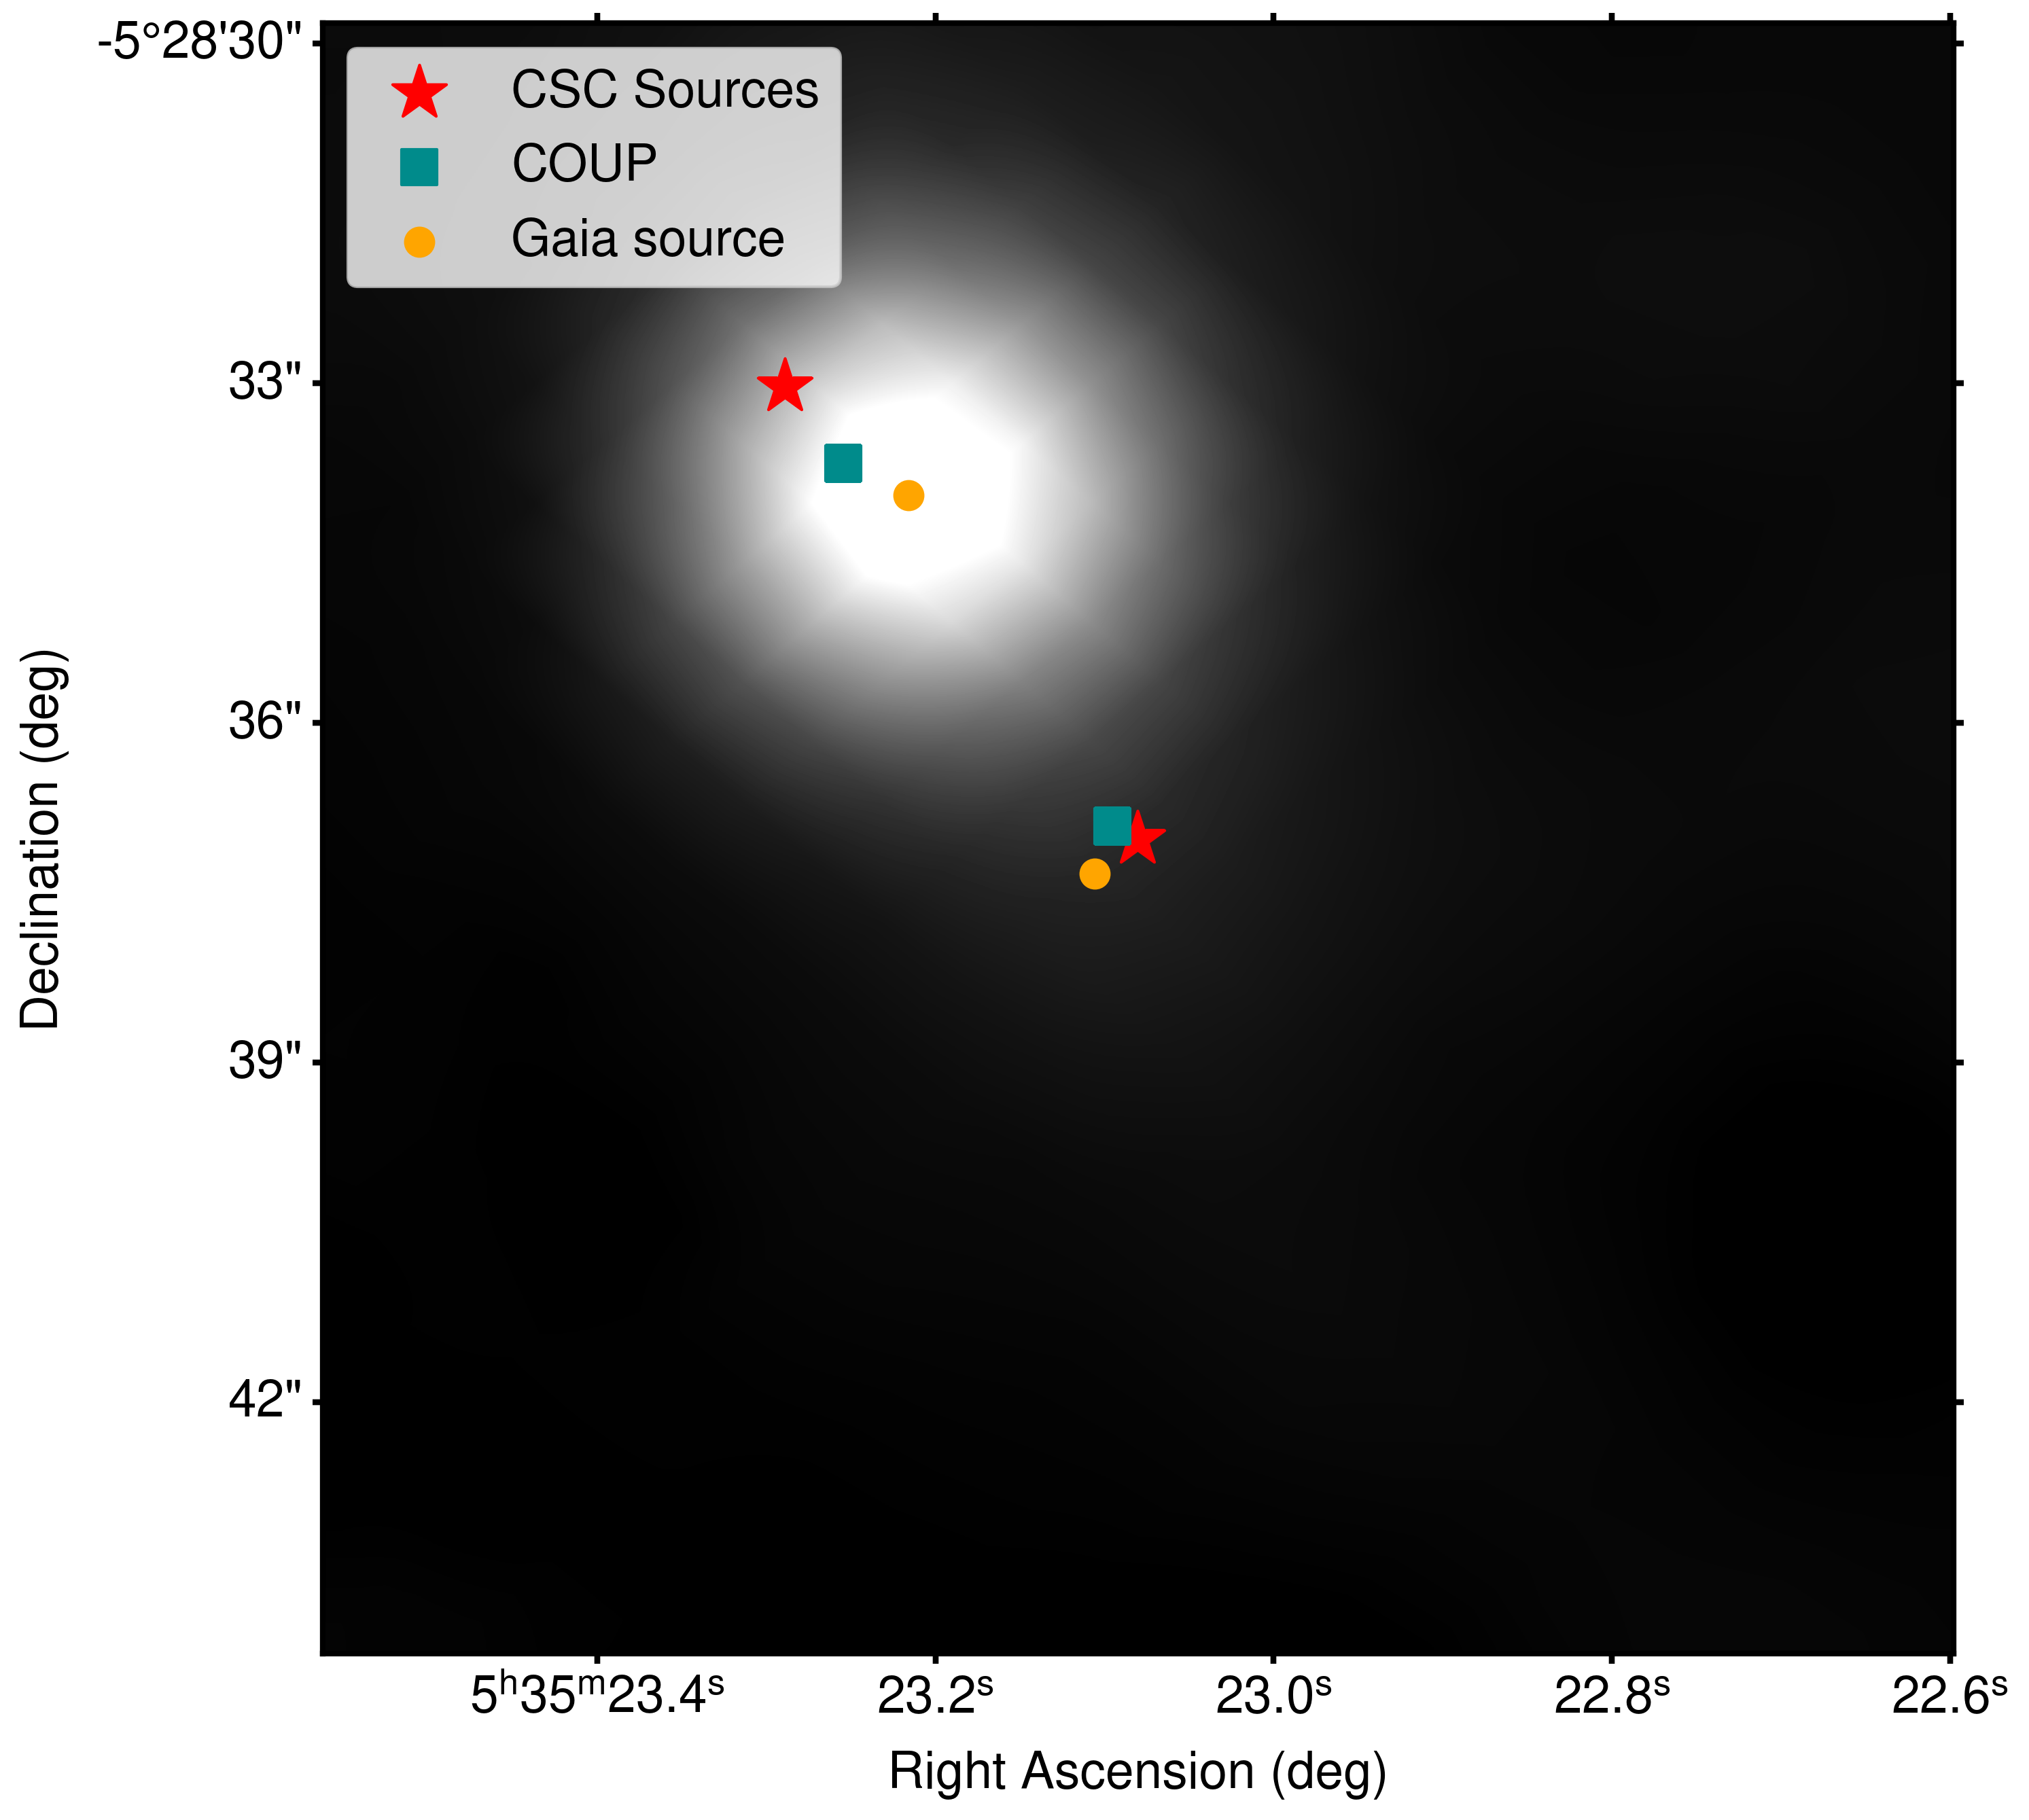

In [47]:
fig = create_validation_plot(result, ref_csc, ref2, ref)

In [ ]:
orion_sources_in_region[orion_sources_in_region['best_for_xray'] == 1].query('p_match_ind <= 0.35')

In [82]:
# how many matches remain vs original
print(f"Original pairs: {len(orion_sources_in_region)}")
print(f"Clean matches: {len(clean_matches)}")

# compare to NWAY's choices
nway_matches = orion_sources_in_region[orion_sources_in_region['match_flag']==1]
overlap = len(set(clean_matches.index) & set(nway_matches.index))
print(f"Overlap with NWAY: {overlap}")

Original pairs: 5941
Clean matches: 1162
Overlap with NWAY: 1000


In [44]:
mismatched_rows = matched_sources[y_true != y_pred]
#mismatched_rows[['csc21_name', 'csc21_ra', 'csc21_dec', 'gaia3_source_id', 'p_any', 'p_i', 'p_match_ind', 'label', 'match_flag', 'separation_from_orion', 'num_possible_counterparts']]

In [45]:
mismatched_rows

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion,num_possible_counterparts,label,best_for_xray,best_for_gaia
1054474,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,3.882515e-01,2,2,0.534150,0.661057,22.152802,2,1,True,True
1054475,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,6.117485e-01,1,2,NaN,0.092227,22.152802,2,0,False,True
1054700,2CXO J053443.1-054439,83.679588,-5.744310,0.400330,0.310460,123.400002,-0.712055,-0.156152,-0.415365,0.078076,...,1.411789e-01,0,2,1.686202,0.919876,22.629261,2,1,True,True
1054701,2CXO J053443.1-054439,83.679588,-5.744310,0.400330,0.310460,123.400002,-0.712055,-0.156152,-0.415365,0.078076,...,8.588212e-01,1,2,NaN,0.101962,22.629261,2,0,False,True
1054839,2CXO J053452.7-052753,83.719856,-5.464969,0.122550,0.122550,81.599998,-0.353529,-0.173641,-0.193004,-0.154279,...,3.222544e-13,0,2,2.457287,0.874533,7.377383,2,1,True,True
1054840,2CXO J053452.7-052753,83.719856,-5.464969,0.122550,0.122550,81.599998,-0.353529,-0.173641,-0.193004,-0.154279,...,1.000000e+00,1,2,2.904803,0.714241,7.377383,2,0,False,True
1054943,2CXO J053457.7-052350,83.740479,-5.397514,0.122550,0.122550,0.000000,-0.614616,-0.099938,-0.131793,-0.069332,...,1.121039e-44,0,2,0.642165,0.928543,4.813454,2,1,True,True
1054944,2CXO J053457.7-052350,83.740479,-5.397514,0.122550,0.122550,0.000000,-0.614616,-0.099938,-0.131793,-0.069332,...,1.000000e+00,1,2,0.666841,0.888319,4.813454,2,0,False,True
1054989,2CXO J053500.1-052301,83.750473,-5.383909,0.122550,0.118465,67.300003,-0.552155,-0.148657,-0.191755,-0.104310,...,2.056966e-03,0,4,NaN,0.823822,4.259632,4,1,True,True
1054991,2CXO J053500.1-052301,83.750473,-5.383909,0.122550,0.118465,67.300003,-0.552155,-0.148657,-0.191755,-0.104310,...,9.979430e-01,1,4,NaN,0.820955,4.259632,4,0,False,True


In [46]:
mismatched_rows.to_csv('../out_data/validation/mismatched_orion_sources_rows_sep2.csv', index=False)

In [25]:
len(mismatched_rows['csc21_name'].unique())

627

In [ ]:
mismatched_csc21_names = mismatched_rows['csc21_name'].unique()
mismatched_full_df = df_all_model[df_all_model['csc21_name'].isin(mismatched_csc21_names)]
mismatched_full_df  

,csc21_name,csc21_ra,csc21_dec,csc21_errmaj,csc21_errmin,csc21_errpa,hard_hs,hard_hm,hard_hm_lolim,hard_hm_hilim,...,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,count,sqrt(pmra^2+pmdec^2),p_match_ind,separation_from_orion
1054474,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,10.798160,9.908483e-01,9.908483e-01,0.996427,0.388252,2,2,0.534150,0.661057,22.152802
1054475,2CXO J053354.5-053159,83.477318,-5.533226,1.017165,0.710790,46.000000,0.018738,-0.258588,-0.612742,0.011868,...,10.995620,9.941723e-01,9.941723e-01,0.996427,0.611749,1,2,NaN,0.092227,22.152802
1054498,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,-53.870602,0.000000e+00,0.000000e+00,0.929077,0.000000,0,3,6.913919,0.278364,17.716681
1054499,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,8.321090,2.652136e-01,2.652136e-01,0.929077,0.027553,0,3,2.120180,0.944319,17.716681
1054500,2CXO J053405.9-052241,83.524857,-5.378230,0.800660,0.690365,21.400000,0.261087,0.026234,-0.055590,0.101811,...,9.868788,9.272142e-01,9.272142e-01,0.929077,0.972447,1,3,1.718079,0.936216,17.716681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060712,2CXO J053619.8-051426,84.082901,-5.240759,3.153620,3.153620,0.000000,0.502186,0.724547,0.489069,0.916302,...,8.912745,5.849905e-01,5.849905e-01,0.586404,0.994193,1,2,0.996231,0.490257,18.160187
1060716,2CXO J053624.5-053450,84.102219,-5.580619,6.956755,3.754115,51.200001,-0.137414,-0.243598,-0.527795,-0.021861,...,9.427318,8.217339e-01,8.217339e-01,0.900415,0.509817,1,2,2.769930,0.388983,20.172741
1060717,2CXO J053624.5-053450,84.102219,-5.580619,6.956755,3.754115,51.200001,-0.137414,-0.243598,-0.527795,-0.021861,...,9.410260,8.159078e-01,8.159078e-01,0.900415,0.490183,2,2,1.195963,0.948562,20.172741
1060721,2CXO J053630.0-052006,84.125053,-5.335166,0.388075,0.167485,173.600006,-0.515928,-0.187383,-0.222986,-0.150531,...,-53.111420,0.000000e+00,0.000000e+00,0.000000,0.000000,0,2,1.473365,0.949671,18.507790


In [86]:
mismatched_full_df.to_csv('../out_data/validation/orion_mismatched_full_df.csv', index=False)

In [87]:
orion_sources_in_region.to_csv('../out_data/validation/orion_sources_in_region.csv', index=False)

In [78]:
mismatched_rows.csc21_name.sample(1).values[0]

'2CXO J053522.8-052226'

In [26]:
src_interest = df_all_model[df_all_model['csc21_name'] == '2CXO J053523.0-052836']
src_interest[['csc21_name', 'csc21_ra', 'csc21_dec', 'gaia3_source_id', 'p_any', 'p_i', 'p_match_ind', 'match_flag', 'separation']]

,csc21_name,csc21_ra,csc21_dec,gaia3_source_id,p_any,p_i,p_match_ind,match_flag,separation
1059673,2CXO J053523.0-052836,83.846169,-5.476952,3017359386099075072,0.997648,4.779405e-31,0.801531,0,3.648854
1059674,2CXO J053523.0-052836,83.846169,-5.476952,3017359390406492288,0.997648,1.000000e+00,0.186806,1,0.487666
1059675,2CXO J053523.0-052836,83.846169,-5.476952,3017359459125972736,0.997648,0.000000e+00,0.761034,0,12.622300


In [74]:
src_interest['p_i'] * src_interest['p_match_ind']

1059673    3.830842e-31
1059674    1.868058e-01
1059675    0.000000e+00
dtype: float64